Imports

#### Ryan Martin
#### CS 6140: Machine Learning
#### 12/12/19
#### Dr. Craig Martell



# Convolutional Neural Network: CIFAR-10 Dataset
## Frame the Problem and Look at the Big Picture:
#### In this dataset, we are given 60000 32x32 colour images in 10 classes, with 6000 images per class and 50000 training images and 10000 test images. Each of these ten classes consist of the following objects: airplane, automobile, bird, cat, deer, dog, frog, horse, ship, and trucks. All these images of listed objects are mutually exclusive, so there are no overlapping classes such as automobiles and trucks because trucks contain only large commercial vehicles.
#### The task in this project is to create a Convolutional Neural Network that will achieve ~75% accuracy without overfitting.

#### For this project, we will be using the Keras library.

## Get the Data:
#### We will download the data in a way that will allow for us to access and monitor the training set and test set and validation set. By using ngrok, we can create a public URL to access the localhost of the ipython environment in Google Colab. This will make it possible for us to access the TensorBoard on our local machine and have more control over the batches of data.

In [0]:
import numpy as np
import pickle
import os
import urllib
import zipfile 
import tarfile
from six.moves import urllib

from __future__ import absolute_import
from __future__ import division
from __future__ import print_function

# tensorflow imports
import tensorflow as tf
from tensorflow.contrib.training import HParams

# tf.keras imports
from tensorflow.keras import Model
from tensorflow.keras.layers import Dense, Conv2D, Activation, Flatten
from tensorflow.keras.layers import MaxPooling2D, Dropout
from tensorflow.keras.layers import BatchNormalization, AveragePooling2D, Input
from tensorflow.keras.preprocessing.image import ImageDataGenerator

from keras.models import Sequential
from keras.optimizers import adam
from keras.utils import np_utils

# import for showing the confusion matrix
import itertools
from sklearn.metrics import confusion_matrix
import matplotlib.pyplot as plt
import numpy as np

Using TensorFlow backend.


#### Download and install [ngrok](https://ngrok.com/). 

In [0]:
! wget https://bin.equinox.io/c/4VmDzA7iaHb/ngrok-stable-linux-amd64.zip
! unzip -o ngrok-stable-linux-amd64.zip

--2019-12-13 04:16:27--  https://bin.equinox.io/c/4VmDzA7iaHb/ngrok-stable-linux-amd64.zip
Resolving bin.equinox.io (bin.equinox.io)... 52.204.223.154, 3.231.170.111, 34.227.147.55, ...
Connecting to bin.equinox.io (bin.equinox.io)|52.204.223.154|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 13773305 (13M) [application/octet-stream]
Saving to: ‘ngrok-stable-linux-amd64.zip’

ngrok-stable-linux- 100%[===================>]  13.13M  19.2MB/s    in 0.7s    

2019-12-13 04:16:28 (19.2 MB/s) - ‘ngrok-stable-linux-amd64.zip’ saved [13773305/13773305]

Archive:  ngrok-stable-linux-amd64.zip
  inflating: ngrok                   


#### Now we can run `ngrok` in the `ipython` environment and tunnel the data to a public, random URL.

In [0]:
# kill all running ngrok instances
!pkill -f ngrok

# Execute tensorboard
!rm rf /tmp/checkpoints
!mkdir /tmp/checkpoints
LOG_DIR = '/tmp/checkpoints/'
get_ipython().system_raw(
    'tensorboard --logdir {} --host 0.0.0.0 --port 6006 &'
    .format(LOG_DIR)
)

# execute ngrok
get_ipython().system_raw('./ngrok http 6006 &')

rm: cannot remove 'rf': No such file or directory
rm: cannot remove '/tmp/checkpoints': No such file or directory





#### The code below outputs a URL containing the TensorBoard visualizations for the classifier we will train and evaluate.

In [0]:
# Do the tunneling
! curl -s http://localhost:4040/api/tunnels | python3 -c \
    "import sys, json; print(json.load(sys.stdin)['tunnels'][0]['public_url'])"

https://2b3a9070.ngrok.io


## Data download and preprocessing

In [0]:

hparams = HParams(
    n_classes=10,  # number of different classes in dataset
    learning_rate=1e-4,  # fixed learning rate
    train_batch_size=32,  # training batch size
    val_batch_size=32,  # validation batch size
    test_batch_size=32,  # testing batch size
    n_epochs=10,  # number of epochs to train
    input_name='input_1',  # name of the input tensor for first layer of Keras model
    data_dir='/tmp/cifar-data/',  # path to data directory
    checkpoint_dir='/tmp/checkpoints/'  # path to model checkpoint directory
)

#### This code is for downloading and preprocessing of the CIFAR-10 dataset.

In [0]:
# URL for the data-set on the internet.
data_url = "https://www.cs.toronto.edu/~kriz/cifar-10-python.tar.gz"

# Width and height of each image.
img_size = 32

# Number of channels in each image, 3 channels: Red, Green, Blue.
num_channels = 3

# Length of an image when flattened to a 1-dim array.
img_size_flat = img_size * img_size * num_channels

# Number of classes.
num_classes = hparams.n_classes

# Number of files for the training-set.
_num_files_train = 5

# Number of images for each batch-file in the training-set.
_images_per_file = 10000

# Total number of images in the training-set.
# This is used to pre-allocate arrays for efficiency.
_num_images_train = _num_files_train * _images_per_file


def download(base_url, filename, download_dir):

    # Path for local file.
    save_path = os.path.join(download_dir, filename)

    # Check if the file already exists, otherwise we need to download it now.
    if not os.path.exists(save_path):
        # Check if the download directory exists, otherwise create it.
        if not os.path.exists(download_dir):
            os.makedirs(download_dir)

        print("Downloading", filename, "...")

        # Download the file from the internet.
        url = base_url + filename
        file_path, _ = urllib.request.urlretrieve(url=url,
                                                  filename=save_path)

        print(" Done!")


def maybe_download_and_extract(url=data_url, download_dir=hparams.data_dir):

    # Filename for saving the file downloaded from the internet.
    # Use the filename from the URL and add it to the download_dir.
    filename = url.split('/')[-1]
    file_path = os.path.join(download_dir, filename)

    # Check if the file already exists.
    # If it exists then we assume it has also been extracted,
    # otherwise we need to download and extract it now.
    if not os.path.exists(file_path):
        # Check if the download directory exists, otherwise create it.
        if not os.path.exists(download_dir):
            os.makedirs(download_dir)

        # Download the file from the internet.
        file_path, _ = urllib.request.urlretrieve(url=url,
                                                  filename=file_path)

        print()
        print("Download finished. Extracting files.")

        if file_path.endswith(".zip"):
            # Unpack the zip-file.
            zipfile.ZipFile(file=file_path, mode="r").extractall(download_dir)
        elif file_path.endswith((".tar.gz", ".tgz")):
            # Unpack the tar-ball.
            tarfile.open(name=file_path, mode="r:gz").extractall(download_dir)

        print("Done.")
    else:
        print("Data has apparently already been downloaded and unpacked.")


def _get_file_path(filename=""):

    return os.path.join(hparams.data_dir, "cifar-10-batches-py/", filename)


def _unpickle(filename):

    # Create full path for the file.
    file_path = _get_file_path(filename)

    print("Loading data: " + file_path)

    with open(file_path, mode='rb') as file:
        # In Python 3.X it is important to set the encoding,
        # otherwise an exception is raised here.
        data = pickle.load(file,encoding='bytes')

    return data


def _convert_images(raw):

    # Convert the raw images from the data-files to floating-points.
    raw_float = np.array(raw, dtype=float) / 255.0

    # Reshape the array to 4-dimensions.
    images = raw_float.reshape([-1, num_channels, img_size, img_size])

    # Reorder the indices of the array.
    images = images.transpose([0, 2, 3, 1])

    return images


def _load_data(filename):

    # Load the pickled data-file.
    data = _unpickle(filename)

    # Get the raw images.
    raw_images = data[b'data']

    # Get the class-numbers for each image. Convert to numpy-array.
    cls = np.array(data[b'labels'])

    # Convert the images.
    images = _convert_images(raw_images)

    return images, cls


def load_class_names():
    # Load the class-names from the pickled file.
    raw = _unpickle(filename="batches.meta")[b'label_names']

    # Convert from binary strings.
    names = [x.decode('utf-8') for x in raw]

    return names


def load_training_data():

    # Pre-allocate the arrays for the images and class-numbers for efficiency.
    images = np.zeros(shape=[_num_images_train, img_size, img_size, num_channels], dtype=float)
    cls = np.zeros(shape=[_num_images_train], dtype=int)

    # Begin-index for the current batch.
    begin = 0

    # For each data-file.
    for i in range(_num_files_train):
        # Load the images and class-numbers from the data-file.
        images_batch, cls_batch = _load_data(filename="data_batch_" + str(i + 1))

        # Number of images in this batch.
        num_images = len(images_batch)

        # End-index for the current batch.
        end = begin + num_images

        # Store the images into the array.
        images[begin:end, :] = images_batch

        # Store the class-numbers into the array.
        cls[begin:end] = cls_batch

        # The begin-index for the next batch is the current end-index.
        begin = end

    return images, cls


def load_validation_data():

    images, cls = _load_data(filename="test_batch")

    images = images[10000:, :, :, :]
    cls = cls[10000:]

    return images, cls

def load_testing_data():


    images, cls = _load_data(filename="test_batch")

    images = images[:10000, :, :, :]
    cls = cls[:10000]

    return images, cls

### Preparation of the Data and Examination of the Data:

#### We have 50000 training and 10000 test images. The images have a structure of (32,32,3) which correspond to (width, height, RGB). The validation set will be "split" with the training data. 

#### For each image there is a corresponding label, which is a class index.



In [0]:

# Download and extract CIFAR-10 data
maybe_download_and_extract()

# training data
x_train, y_train = load_training_data()

# Validation data
x_val, y_val = load_validation_data()

# Testing data
x_test, y_test = load_testing_data()

print(np.array(x_train).shape)
print(np.array(y_train).shape)
print(x_test.shape)
print(y_test.shape)


Download finished. Extracting files.
Done.
Loading data: /tmp/cifar-data/cifar-10-batches-py/data_batch_1
Loading data: /tmp/cifar-data/cifar-10-batches-py/data_batch_2
Loading data: /tmp/cifar-data/cifar-10-batches-py/data_batch_3
Loading data: /tmp/cifar-data/cifar-10-batches-py/data_batch_4
Loading data: /tmp/cifar-data/cifar-10-batches-py/data_batch_5
Loading data: /tmp/cifar-data/cifar-10-batches-py/test_batch
Loading data: /tmp/cifar-data/cifar-10-batches-py/test_batch
(50000, 32, 32, 3)
(50000,)
(10000, 32, 32, 3)
(10000,)


#### We will preprocess the data by transforming the features to float32 type, normalizing them, and one_hot_encoding the labels. 

In [0]:
# Transforming the features

mean = np.mean(x_train,axis=(0,1,2,3))
std = np.std(x_train,axis=(0,1,2,3))
x_train = (x_train-mean)/(std+1e-7)
x_test = (x_test-mean)/(std+1e-7)


# One-hot encoding the labels
nClasses = 10
y_train = np_utils.to_categorical(y_train, nClasses)
y_test = np_utils.to_categorical(y_test, nClasses)



In [0]:
print("Shape of training data:")
print(x_train.shape)
print(y_train.shape)
print("Shape of test data:")
print(x_test.shape)
print(y_test.shape)

Shape of training data:
(50000, 32, 32, 3)
(50000, 10)
Shape of test data:
(10000, 32, 32, 3)
(10000, 10)


In [0]:
input_shape = (32,32,3)

#### These methods will help later in the stage of evaluating our model with training accuracy and validation accuracy to check for overfitting. 

In [0]:
def plot_curves(history):
  plt.figure(figsize=[8,6])
  plt.plot(history.history['acc'])
  plt.plot(history.history['val_acc'])
  plt.legend(['Training Accuracy', 'Validation Accuracy'], 
           loc = 'lower right')
  plt.xlabel('Epochs ')
  plt.ylabel('Accuracy')
  plt.title('Accuracy Curves')
  plt.show()

In [0]:
def plot_losses(history):  
    plt.figure(figsize=[8,6])
    plt.plot(history.history['loss'])
    plt.plot(history.history['val_loss'])
    plt.title('model loss')
    plt.ylabel('loss')
    plt.xlabel('epoch')
    plt.legend(['train', 'validation'], loc='upper left')
    plt.show()

## Select and Train a Model


### CNN Classifier

#### A Convolutional Neural Network contains a convolutional layer and a pooling layer. The convolutional layer has neurons in the first layer, which are unconnected to the pixels in the input image but fully connected to the pixels in their receptive fields. Each neuron in the second convolutional layer is connected only to neurons in the small rectangle in the first layer. This architecture creates an environment for the network to concentrate on low-level features in the first hidden layer, and then assemble them to higher-level features in the next hidden layer. Because this heirarchial structure is common in real-world images, CNN's succeed in these image recognition problems. In addition to the convolutional layer, there are pooling layers that take a subsample of the input image in order to reduce the computational complexity and parameters, which limits the probability of overfitting. (See model below). 

#### We will first experiment with different weight decays. In this experiment, we will attempt to reduce the training error and test error by reducing the gap between training and test error. In changing the regularization hyperparameters, we can reduce effective model capacity. We will start at a small decay, and then decrease it to zero. 

### CNN Model: Weight Decay 0.0005 

In [0]:
from keras.layers import Dense, Flatten
from keras.layers import Conv2D, MaxPooling2D
from keras.optimizers import SGD

model = Sequential()

model.add(Conv2D(32, (3, 3), activation='relu', input_shape=(32, 32, 3)))
model.add(Conv2D(32, (3, 3), activation='relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))

model.add(Flatten())
model.add(Dense(256, activation='relu'))
model.add(Dense(10, activation='softmax'))

sgd = SGD(lr=0.01, decay=0.0005, momentum=0.9, nesterov=True)
model.compile(loss='categorical_crossentropy', metrics=['accuracy'], optimizer=sgd)

In [0]:
history = model.fit(x_train, y_train, batch_size=32, epochs=20, verbose=2, validation_split=0.2)

Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where



Train on 40000 samples, validate on 10000 samples
Epoch 1/20





 - 12s - loss: 1.3130 - acc: 0.5311 - val_loss: 1.0645 - val_acc: 0.6264
Epoch 2/20
 - 6s - loss: 0.8885 - acc: 0.6877 - val_loss: 0.9405 - val_acc: 0.6656
Epoch 3/20
 - 5s - loss: 0.6299 - acc: 0.7800 - val_loss: 0.9281 - val_acc: 0.6822
Epoch 4/20
 - 5s - loss: 0.3931 - acc: 0.8654 - val_loss: 1.0345 - val_acc: 0.6885
Epoch 5/20
 - 6s - loss: 0.1924 - acc: 0.9393 - val_loss: 1.2265 - val_acc: 0.6825
Epoch 6/20
 - 6s - loss: 0.0740 - acc: 0.9814 - val_loss: 1.3996 - val_acc: 0.6957
Epoch 7/20
 - 5s - loss: 0.0233 - acc: 0.9970 - val_loss: 1.5461 - val_acc: 0.6996
Epoch 8/20
 - 5s - loss: 0.0087 - acc: 0.9995 - val_loss: 1.6417 - val_acc: 0.6995
Epoch 9/20
 - 5s - loss: 0.0047 - acc: 0.9999 - val_loss: 1.7181 - val_acc: 0.7018
Epoch 10/20
 - 5s - loss: 0.0036 - acc: 0.9999 - val_loss: 1.7616 - val_acc: 0.7012
Epoch 11/20
 - 5

#### In plotting the training accuracy and the validation accuracy, we can see the training accuracy curve intersects the validation accuracy curve in the plot below and creates a large gap between the two curves. This unfortunately means that our model has overfitted, and although our training accuracy has reached 100%, our testing data on evaluation would most likely not surpass 69% acccuracy because our loss score is way too high (2.04). This puts our accuracy below the industry standard of 75%. 

#### We can then continue our experiment in training CNN's with different hyperparameters to find a model that will generalize to new data at or above industry level. 

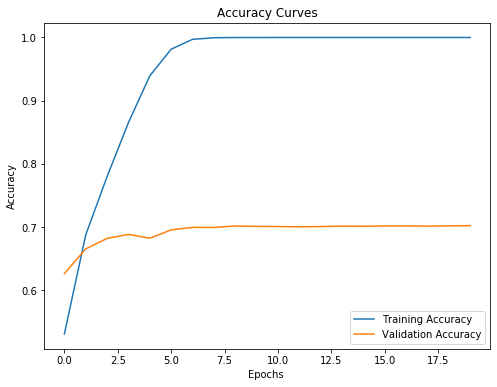

In [0]:
plot_curves(history)

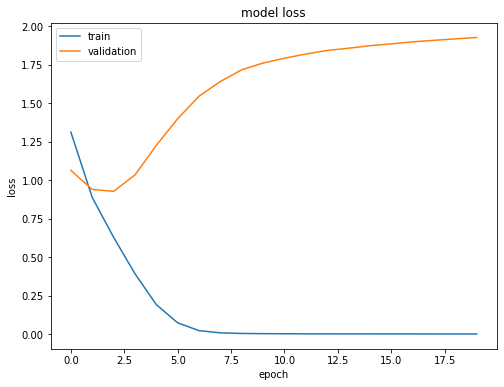

In [0]:
plot_losses(history)

In [0]:
score = model.evaluate(x_test, y_test, batch_size=128, verbose=0)

In [0]:
print(model.metrics_names)
print(score)

['loss', 'acc']
[2.0442402618408204, 0.6917]


### CNN Model: Weight Decay 0.00005

#### Hypothesis: By lowering the weight decay, capacity will be increased, freeing the model parameters to become larger. This will reduce overfitting. 

In [0]:
from keras.layers import Dense, Flatten
from keras.layers import Conv2D, MaxPooling2D
from keras.optimizers import SGD

model = Sequential()

model.add(Conv2D(32, (3, 3), activation='relu', input_shape=(32, 32, 3)))
model.add(Conv2D(32, (3, 3), activation='relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))

model.add(Flatten())
model.add(Dense(256, activation='relu'))
model.add(Dense(10, activation='softmax'))

sgd = SGD(lr=0.01, decay=0.00005, momentum=0.9, nesterov=True)
model.compile(loss='categorical_crossentropy', metrics=['accuracy'], optimizer=sgd)

In [0]:
history = model.fit(x_train, y_train, batch_size=32, epochs=20, verbose=2, validation_split=0.2)

Train on 40000 samples, validate on 10000 samples
Epoch 1/20
 - 6s - loss: 1.3417 - acc: 0.5187 - val_loss: 1.1004 - val_acc: 0.6181
Epoch 2/20
 - 5s - loss: 0.9218 - acc: 0.6760 - val_loss: 0.9977 - val_acc: 0.6546
Epoch 3/20
 - 5s - loss: 0.6496 - acc: 0.7707 - val_loss: 1.0004 - val_acc: 0.6650
Epoch 4/20
 - 5s - loss: 0.3903 - acc: 0.8641 - val_loss: 1.1354 - val_acc: 0.6697
Epoch 5/20
 - 5s - loss: 0.2098 - acc: 0.9276 - val_loss: 1.4239 - val_acc: 0.6679
Epoch 6/20
 - 5s - loss: 0.1279 - acc: 0.9568 - val_loss: 1.5906 - val_acc: 0.6758
Epoch 7/20
 - 5s - loss: 0.0786 - acc: 0.9742 - val_loss: 1.7957 - val_acc: 0.6780
Epoch 8/20
 - 5s - loss: 0.0525 - acc: 0.9823 - val_loss: 2.1065 - val_acc: 0.6598
Epoch 9/20
 - 5s - loss: 0.0523 - acc: 0.9828 - val_loss: 2.0240 - val_acc: 0.6797
Epoch 10/20
 - 5s - loss: 0.0246 - acc: 0.9920 - val_loss: 2.2265 - val_acc: 0.6752
Epoch 11/20
 - 5s - loss: 0.0144 - acc: 0.9957 - val_loss: 2.2057 - val_acc: 0.6813
Epoch 12/20
 - 5s - loss: 0.0085 - 

#### In comparing the curves below with the curves above, we have not solved our problem of overfitting by decreasing the decay. In seems that freeing the model parameters to become larger has actually made our overfitting problem worse. Our loss score is now 2.47 instead of 2.04. 

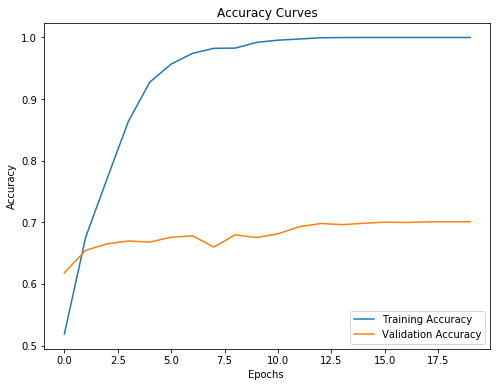

In [0]:
plot_curves(history)

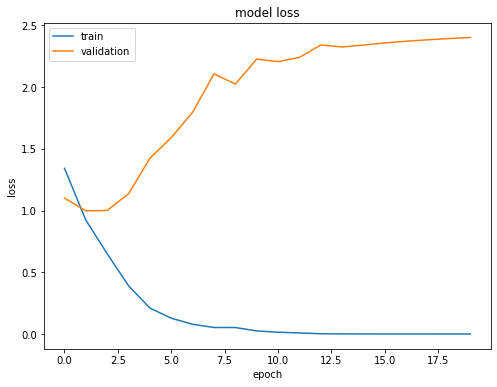

In [0]:
plot_losses(history)

In [0]:
score = model.evaluate(x_test, y_test, batch_size=128, verbose=0)

In [0]:
print(model.metrics_names)
print(score)

['loss', 'acc']
[2.4784544437408447, 0.6932]


### CNN Model: Weight Decay 0.05

#### Hypothesis: Since decreasing our weight decay increased overfitting, we will now increase our weight decay to hopefully get the opposite effect. 

In [0]:
from keras.layers import Dense, Flatten
from keras.layers import Conv2D, MaxPooling2D
from keras.optimizers import SGD

model = Sequential()

model.add(Conv2D(32, (3, 3), activation='relu', input_shape=(32, 32, 3)))
model.add(Conv2D(32, (3, 3), activation='relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))

model.add(Flatten())
model.add(Dense(256, activation='relu'))
model.add(Dense(10, activation='softmax'))

sgd = SGD(lr=0.01, decay=0.05, momentum=0.9, nesterov=True)
model.compile(loss='categorical_crossentropy', metrics=['accuracy'], optimizer=sgd)

In [0]:
history = model.fit(x_train, y_train, batch_size=32, epochs=20, verbose=2, validation_split=0.2)

Train on 40000 samples, validate on 10000 samples
Epoch 1/20
 - 6s - loss: 1.5949 - acc: 0.4345 - val_loss: 1.4827 - val_acc: 0.4779
Epoch 2/20
 - 5s - loss: 1.4209 - acc: 0.5011 - val_loss: 1.4334 - val_acc: 0.4935
Epoch 3/20
 - 5s - loss: 1.3764 - acc: 0.5154 - val_loss: 1.4037 - val_acc: 0.5032
Epoch 4/20
 - 5s - loss: 1.3501 - acc: 0.5264 - val_loss: 1.3871 - val_acc: 0.5085
Epoch 5/20
 - 5s - loss: 1.3314 - acc: 0.5340 - val_loss: 1.3739 - val_acc: 0.5149
Epoch 6/20
 - 5s - loss: 1.3168 - acc: 0.5387 - val_loss: 1.3642 - val_acc: 0.5182
Epoch 7/20
 - 5s - loss: 1.3053 - acc: 0.5440 - val_loss: 1.3547 - val_acc: 0.5216
Epoch 8/20
 - 5s - loss: 1.2954 - acc: 0.5465 - val_loss: 1.3476 - val_acc: 0.5238
Epoch 9/20
 - 6s - loss: 1.2870 - acc: 0.5483 - val_loss: 1.3416 - val_acc: 0.5300
Epoch 10/20
 - 6s - loss: 1.2797 - acc: 0.5511 - val_loss: 1.3358 - val_acc: 0.5297
Epoch 11/20
 - 5s - loss: 1.2729 - acc: 0.5549 - val_loss: 1.3308 - val_acc: 0.5332
Epoch 12/20
 - 5s - loss: 1.2670 - 

#### The results of this model are interesting. We increased our decay to .05 and have greatly reduced our gap in training accuracy and validation accuracy. However, our overfitting is still somewhat significant and our accuracy is too low for industry standards. We will continue our experimentation with hyperparameter tuning. 

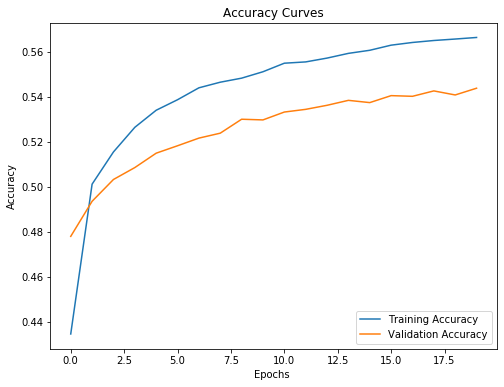

In [0]:
plot_curves(history)

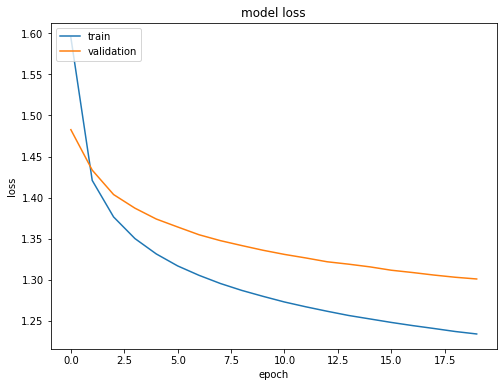

In [0]:
plot_losses(history)

In [0]:
score = model.evaluate(x_test, y_test, batch_size=128, verbose=0)

In [0]:
print(model.metrics_names)
print(score)

['loss', 'acc']
[1.284461966896057, 0.5452]


### CNN Model: Weight Decay 0.0

#### We will train our model with 0.0 decay to see what the effect is on the model. 

####Hypothesis: Decreasing the weight decay to 0.0 will free the model parameters to become larger, which might increase overfitting the most we have seen so far. 


In [0]:
from keras.layers import Dense, Flatten
from keras.layers import Conv2D, MaxPooling2D
from keras.optimizers import SGD

model = Sequential()

model.add(Conv2D(32, (3, 3), activation='relu', input_shape=(32, 32, 3)))
model.add(Conv2D(32, (3, 3), activation='relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))

model.add(Flatten())
model.add(Dense(256, activation='relu'))
model.add(Dense(10, activation='softmax'))

sgd = SGD(lr=0.01, decay=0.0, momentum=0.9, nesterov=True)
model.compile(loss='categorical_crossentropy', metrics=['accuracy'], optimizer=sgd)

In [0]:
history = model.fit(x_train, y_train, batch_size=32, epochs=20, verbose=2, validation_split=0.2)

Train on 40000 samples, validate on 10000 samples
Epoch 1/20
 - 6s - loss: 1.3340 - acc: 0.5236 - val_loss: 1.0779 - val_acc: 0.6144
Epoch 2/20
 - 5s - loss: 0.9263 - acc: 0.6755 - val_loss: 0.9950 - val_acc: 0.6570
Epoch 3/20
 - 5s - loss: 0.6771 - acc: 0.7611 - val_loss: 1.0385 - val_acc: 0.6583
Epoch 4/20
 - 5s - loss: 0.4344 - acc: 0.8484 - val_loss: 1.1560 - val_acc: 0.6645
Epoch 5/20
 - 5s - loss: 0.2791 - acc: 0.9048 - val_loss: 1.4351 - val_acc: 0.6634
Epoch 6/20
 - 5s - loss: 0.2131 - acc: 0.9273 - val_loss: 1.6085 - val_acc: 0.6548
Epoch 7/20
 - 5s - loss: 0.1714 - acc: 0.9428 - val_loss: 1.8872 - val_acc: 0.6466
Epoch 8/20
 - 5s - loss: 0.1360 - acc: 0.9550 - val_loss: 1.9527 - val_acc: 0.6544
Epoch 9/20
 - 5s - loss: 0.1459 - acc: 0.9530 - val_loss: 1.9017 - val_acc: 0.6678
Epoch 10/20
 - 5s - loss: 0.1174 - acc: 0.9628 - val_loss: 2.2001 - val_acc: 0.6591
Epoch 11/20
 - 5s - loss: 0.1168 - acc: 0.9645 - val_loss: 2.3923 - val_acc: 0.6601
Epoch 12/20
 - 5s - loss: 0.1202 - 

#### As expected, the model has severly overfitted with a loss of 3.06, the highest so far.

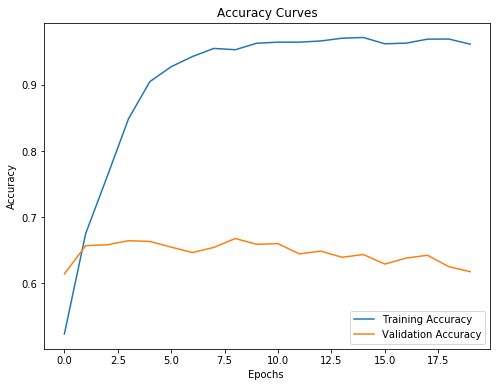

In [0]:
plot_curves(history)

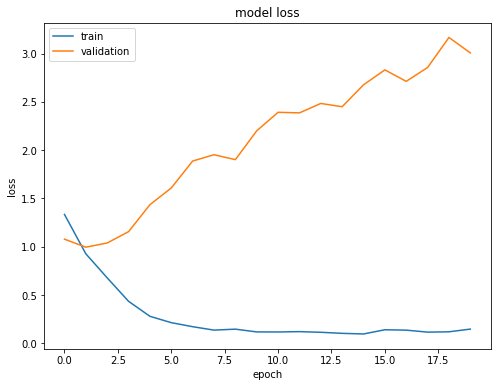

In [0]:
plot_losses(history)

In [0]:
score = model.evaluate(x_test, y_test, batch_size=128, verbose=0)

In [0]:
print(model.metrics_names)
print(score)

['loss', 'acc']
[3.0628340278625488, 0.6155]


### CNN with Dropout:

#### CNN's and other Deep Neural Networks have hundreds of thousands of parameters, which make them prone to overfitting. Certain regularization techniques, such as Dropout, can prevent overfitting so the models can generalize better. 

#### Dropout works by masking a random subset of a neural network for every input of probability p and scaling up the rest of the inputs by 1(1 - p). During training, masking prevents gradient backpropagation through the masked outputs. 

#### During testing, dropout will set p to zero, so that the expected layer of outputs are the same during training and testing. 

### CNN Model: Dropout Layer with 0.0 Weight Decay



In [0]:
from keras.layers import Dense, Dropout, Flatten
from keras.layers import Conv2D, MaxPooling2D

model = Sequential()

model.add(Conv2D(32, (3, 3), activation='relu', input_shape=(32, 32, 3)))
model.add(Conv2D(32, (3, 3), activation='relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))
# Dropout layer added here
model.add(Dropout(0.25))

model.add(Flatten())
model.add(Dense(256, activation='relu'))
# Dropout layer added here
model.add(Dropout(0.5))
model.add(Dense(10, activation='softmax'))

sgd = SGD(lr=0.01, decay=0.0, momentum=0.9, nesterov=True)
model.compile(loss='categorical_crossentropy', metrics=['accuracy'], optimizer=sgd)


Instructions for updating:
Please use `rate` instead of `keep_prob`. Rate should be set to `rate = 1 - keep_prob`.


In [0]:
history = model.fit(x_train, y_train, batch_size=32, epochs=20, verbose=2, validation_split=0.2)

Train on 40000 samples, validate on 10000 samples
Epoch 1/20
 - 6s - loss: 1.5348 - acc: 0.4446 - val_loss: 1.2440 - val_acc: 0.5582
Epoch 2/20
 - 6s - loss: 1.2106 - acc: 0.5722 - val_loss: 1.0371 - val_acc: 0.6323
Epoch 3/20
 - 6s - loss: 1.0917 - acc: 0.6183 - val_loss: 1.0765 - val_acc: 0.6179
Epoch 4/20
 - 6s - loss: 1.0153 - acc: 0.6421 - val_loss: 0.9942 - val_acc: 0.6554
Epoch 5/20
 - 6s - loss: 0.9366 - acc: 0.6709 - val_loss: 0.9812 - val_acc: 0.6597
Epoch 6/20
 - 6s - loss: 0.8757 - acc: 0.6895 - val_loss: 0.9550 - val_acc: 0.6714
Epoch 7/20
 - 6s - loss: 0.8260 - acc: 0.7063 - val_loss: 0.9890 - val_acc: 0.6677
Epoch 8/20
 - 6s - loss: 0.7834 - acc: 0.7231 - val_loss: 0.9575 - val_acc: 0.6735
Epoch 9/20
 - 6s - loss: 0.7454 - acc: 0.7377 - val_loss: 0.9877 - val_acc: 0.6707
Epoch 10/20
 - 6s - loss: 0.7242 - acc: 0.7504 - val_loss: 0.9958 - val_acc: 0.6700
Epoch 11/20
 - 6s - loss: 0.6962 - acc: 0.7594 - val_loss: 1.0299 - val_acc: 0.6704
Epoch 12/20
 - 6s - loss: 0.6558 - 

#### As seen in our accuracy curves and loss curves, we did prevent over fitting to an extent with dropout, but our validation accuracy with no decay suffered. 


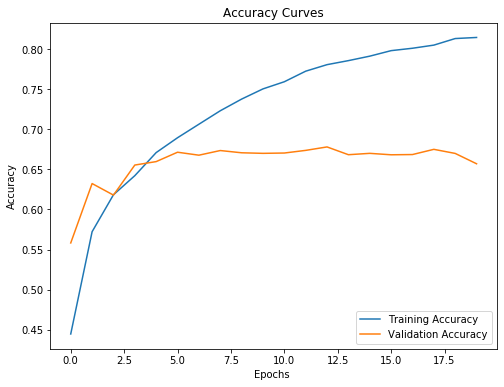

In [0]:
plot_curves(history)

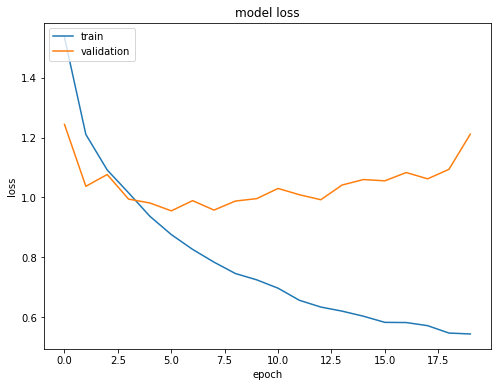

In [0]:
plot_losses(history)

In [0]:
score = model.evaluate(x_test, y_test, batch_size=128, verbose=0)

In [0]:
print(model.metrics_names)
print(score)

['loss', 'acc']
[1.2254878425598144, 0.6513]


### CNN Model: Dropout Layer with Weight Decay

####Hypothesis: With these finely tuned parameters, we will most likely see our most accurate and least overfitted model yet. 

In [0]:
from keras.layers import Dense, Dropout, Flatten
from keras.layers import Conv2D, MaxPooling2D

model = Sequential()

model.add(Conv2D(32, (3, 3), activation='relu', input_shape=(32, 32, 3)))
model.add(Conv2D(32, (3, 3), activation='relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))
# Dropout layer added here
model.add(Dropout(0.25))

model.add(Flatten())
model.add(Dense(256, activation='relu'))
# Dropout layer added here
model.add(Dropout(0.5))
model.add(Dense(10, activation='softmax'))

sgd = SGD(lr=0.01, decay=1e-6, momentum=0.9, nesterov=True)
model.compile(loss='categorical_crossentropy', metrics=['accuracy'], optimizer=sgd)

In [0]:
history = model.fit(x_train, y_train, batch_size=32, epochs=20, verbose=2, validation_split=0.2)

Train on 40000 samples, validate on 10000 samples
Epoch 1/20
 - 6s - loss: 1.5476 - acc: 0.4405 - val_loss: 1.2485 - val_acc: 0.5524
Epoch 2/20
 - 6s - loss: 1.2266 - acc: 0.5655 - val_loss: 1.0753 - val_acc: 0.6266
Epoch 3/20
 - 6s - loss: 1.1071 - acc: 0.6093 - val_loss: 1.0251 - val_acc: 0.6446
Epoch 4/20
 - 6s - loss: 1.0144 - acc: 0.6442 - val_loss: 1.0270 - val_acc: 0.6362
Epoch 5/20
 - 6s - loss: 0.9389 - acc: 0.6681 - val_loss: 0.9826 - val_acc: 0.6585
Epoch 6/20
 - 6s - loss: 0.8780 - acc: 0.6929 - val_loss: 1.0105 - val_acc: 0.6501
Epoch 7/20
 - 6s - loss: 0.8212 - acc: 0.7125 - val_loss: 0.9717 - val_acc: 0.6721
Epoch 8/20
 - 6s - loss: 0.7776 - acc: 0.7255 - val_loss: 0.9338 - val_acc: 0.6875
Epoch 9/20
 - 6s - loss: 0.7407 - acc: 0.7419 - val_loss: 0.9689 - val_acc: 0.6774
Epoch 10/20
 - 6s - loss: 0.7066 - acc: 0.7539 - val_loss: 0.9714 - val_acc: 0.6744
Epoch 11/20
 - 6s - loss: 0.6661 - acc: 0.7676 - val_loss: 0.9925 - val_acc: 0.6774
Epoch 12/20
 - 6s - loss: 0.6535 - 

#### The results of these curves were also disappointing. We see no reduction in overfitting from the previous model and the accuracy still lingers at around 67%. We must try different techniques such as regularization to create better results. 

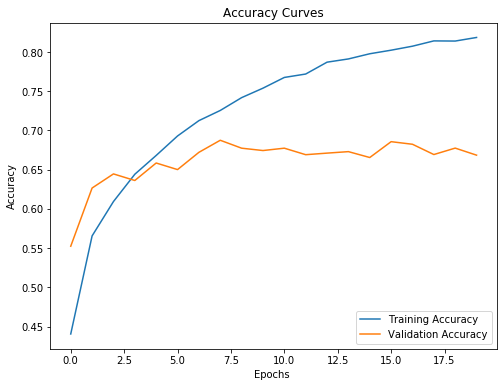

In [0]:
plot_curves(history)

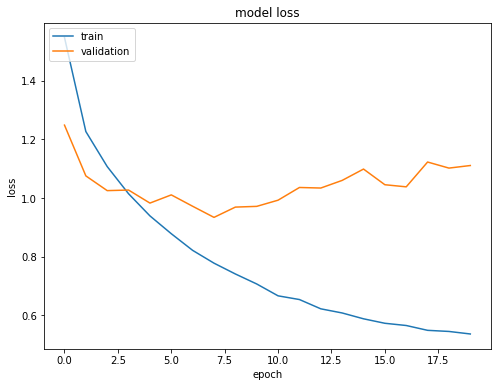

In [0]:
plot_losses(history)

In [0]:
score = model.evaluate(x_test, y_test, batch_size=128, verbose=0)

In [0]:
print(model.metrics_names)
print(score)

['loss', 'acc']
[1.1180916896820068, 0.6651]


## Batch Normalization: 

#### Batch Normalization is a technique that addresses the issue of vanishing/exploding gradients, and also the problem involving the distribution of each layer's inputs changing during training while the parameters of the previous layer change synchronously. This is known as the *Internal Covariate Shift* problem. 

#### Batch Normalization accomplishes this task by adding an operation in the model just before the activation function of each layer, simply zero-centering and normalizing the inputs, and then scaling and shifting the result with two new parameters per layer. This operation basically forces the model to learn the optimal scale and mean of the inputs per layer. 

#### The following equations show the step by step process the algorithm performs to estimate the inputs mean and standard deviation by evaluating the mean and deviation of the inputs over the current mini-batch. 

#### Step 1: Finds the empirical mean over the whole mini-batch. 


In [0]:
from IPython.display import Math, HTML
display(HTML("<script src='https://cdnjs.cloudflare.com/ajax/libs/mathjax/2.7.3/"
               "latest.js?config=default'></script>"))

Math(r'\mu_B \leftarrow \frac{1}{m}\sum_{i = 1}^{m}x_i')

<IPython.core.display.Math object>

#### Step 2: Finds the empirical standard deviation evaluated over the whole mini-batch.

In [0]:
from IPython.display import Math, HTML
display(HTML("<script src='https://cdnjs.cloudflare.com/ajax/libs/mathjax/2.7.3/"
               "latest.js?config=default'></script>"))

Math(r'\sigma_B^2 \leftarrow \frac{1}{m} \sum_{i=1}^{m}(x_i - \mu_B)^2')

<IPython.core.display.Math object>

#### Step 3: Produces the zero-centered, normalized input.

In [0]:
from IPython.display import Math, HTML
display(HTML("<script src='https://cdnjs.cloudflare.com/ajax/libs/mathjax/2.7.3/"
               "latest.js?config=default'></script>"))

Math(r'\hat{x_i} \leftarrow \frac{x_i - \mu_B}{\sqrt{\sigma_B^2 + \epsilon}}')

<IPython.core.display.Math object>

#### Step 4: The entire output of the Batch Normalization algorithm: it returns a scaled and shifted version of the inputs. 

In [0]:
from IPython.display import Math, HTML
display(HTML("<script src='https://cdnjs.cloudflare.com/ajax/libs/mathjax/2.7.3/"
               "latest.js?config=default'></script>"))

Math(r'y_i \leftarrow \gamma \hat{x_i} + \beta \equiv \mbox{BN}_{\gamma,\beta}(x_i)')

<IPython.core.display.Math object>

#### We will now continue optimizing our model with Batch Normalization, while keeping our Dropout rate with decay and CNN layers the same. 

In [0]:
from keras.layers import Dense, Flatten, Activation
from keras.layers import Conv2D, MaxPooling2D
from keras.layers.normalization import BatchNormalization

model = Sequential()

model.add(Conv2D(32, (3, 3), activation='relu', input_shape=(32, 32, 3)))
model.add(Conv2D(32, (3, 3)))
# Batch normalization layer added here
model.add(BatchNormalization())
model.add(Activation('relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Dropout(0.25))

model.add(Flatten())
model.add(Dense(256))
# Batch normalization layer added here
model.add(BatchNormalization())
model.add(Activation('relu'))
model.add(Dropout(0.5))
model.add(Dense(10, activation='softmax'))

sgd = SGD(lr=0.01, decay=1e-6, momentum=0.9, nesterov=True)
model.compile(loss='categorical_crossentropy', metrics=['accuracy'], optimizer=sgd)

In [0]:
history = model.fit(x_train, y_train, batch_size=32, epochs=20, verbose=2, validation_split=0.2)

Train on 40000 samples, validate on 10000 samples
Epoch 1/20
 - 8s - loss: 1.5453 - acc: 0.4478 - val_loss: 1.1670 - val_acc: 0.5828
Epoch 2/20
 - 8s - loss: 1.2015 - acc: 0.5712 - val_loss: 1.0032 - val_acc: 0.6448
Epoch 3/20
 - 8s - loss: 1.0536 - acc: 0.6253 - val_loss: 0.9519 - val_acc: 0.6643
Epoch 4/20
 - 8s - loss: 0.9535 - acc: 0.6581 - val_loss: 0.9228 - val_acc: 0.6751
Epoch 5/20
 - 8s - loss: 0.8838 - acc: 0.6873 - val_loss: 0.8669 - val_acc: 0.7003
Epoch 6/20
 - 8s - loss: 0.8218 - acc: 0.7087 - val_loss: 0.8469 - val_acc: 0.7079
Epoch 7/20
 - 8s - loss: 0.7667 - acc: 0.7290 - val_loss: 0.8408 - val_acc: 0.7122
Epoch 8/20
 - 8s - loss: 0.7225 - acc: 0.7417 - val_loss: 0.8292 - val_acc: 0.7109
Epoch 9/20
 - 8s - loss: 0.6767 - acc: 0.7589 - val_loss: 0.8169 - val_acc: 0.7234
Epoch 10/20
 - 8s - loss: 0.6403 - acc: 0.7722 - val_loss: 0.7874 - val_acc: 0.7317
Epoch 11/20
 - 8s - loss: 0.6133 - acc: 0.7821 - val_loss: 0.8363 - val_acc: 0.7196
Epoch 12/20
 - 8s - loss: 0.5751 - 

#### In viewing the plots, we see a slight improvement in the loss and accuracy curves. Our validation accuracy is also increasing, which means that our model with generalize more with new data at around 73% accuracy, but we might need to tune our dropout level to reach a better overall evaluation. 

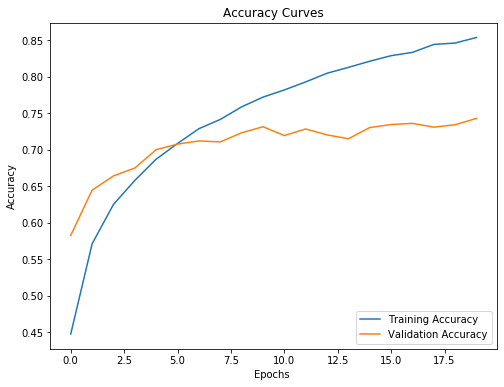

In [0]:
plot_curves(history)

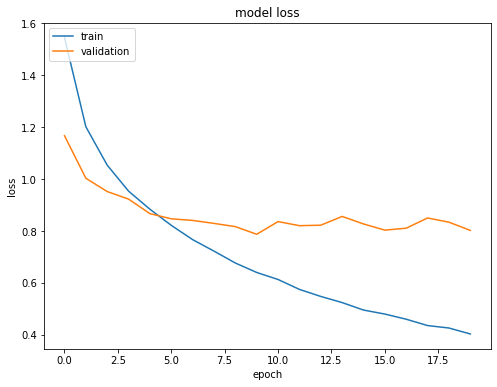

In [0]:
plot_losses(history)

In [0]:
score = model.evaluate(x_test, y_test, batch_size=128, verbose=0)

In [0]:
print(model.metrics_names)
print(score)

['loss', 'acc']
[0.8316235427856445, 0.7291]


#### We will train the same model, but with a minor change to the second dropout instance. We will decrease it from .5 to .4

In [0]:
from keras.layers import Dense, Flatten, Activation
from keras.layers import Conv2D, MaxPooling2D
from keras.layers.normalization import BatchNormalization

model = Sequential()

model.add(Conv2D(32, (3, 3), activation='relu', input_shape=(32, 32, 3)))
model.add(Conv2D(32, (3, 3)))
# Batch normalization layer added here
model.add(BatchNormalization())
model.add(Activation('relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Dropout(0.25))

model.add(Flatten())
model.add(Dense(256))
# Batch normalization layer added here
model.add(BatchNormalization())
model.add(Activation('relu'))
model.add(Dropout(0.4))
model.add(Dense(10, activation='softmax'))

sgd = SGD(lr=0.01, decay=1e-6, momentum=0.9, nesterov=True)
model.compile(loss='categorical_crossentropy', metrics=['accuracy'], optimizer=sgd)

In [0]:
history = model.fit(x_train, y_train, batch_size=32, epochs=20, verbose=2, validation_split=0.2)

Train on 40000 samples, validate on 10000 samples
Epoch 1/20
 - 9s - loss: 1.4730 - acc: 0.4755 - val_loss: 1.1305 - val_acc: 0.5951
Epoch 2/20
 - 8s - loss: 1.1309 - acc: 0.5995 - val_loss: 1.0290 - val_acc: 0.6260
Epoch 3/20
 - 8s - loss: 0.9775 - acc: 0.6537 - val_loss: 0.8819 - val_acc: 0.6882
Epoch 4/20
 - 8s - loss: 0.8868 - acc: 0.6881 - val_loss: 0.9065 - val_acc: 0.6826
Epoch 5/20
 - 8s - loss: 0.8119 - acc: 0.7119 - val_loss: 0.8484 - val_acc: 0.7003
Epoch 6/20
 - 8s - loss: 0.7441 - acc: 0.7369 - val_loss: 0.8487 - val_acc: 0.7025
Epoch 7/20
 - 8s - loss: 0.6935 - acc: 0.7543 - val_loss: 0.8050 - val_acc: 0.7181
Epoch 8/20
 - 8s - loss: 0.6400 - acc: 0.7752 - val_loss: 0.8058 - val_acc: 0.7163
Epoch 9/20
 - 8s - loss: 0.5966 - acc: 0.7884 - val_loss: 0.8265 - val_acc: 0.7197
Epoch 10/20
 - 8s - loss: 0.5477 - acc: 0.8042 - val_loss: 0.7941 - val_acc: 0.7299
Epoch 11/20
 - 8s - loss: 0.5132 - acc: 0.8170 - val_loss: 0.8757 - val_acc: 0.7125
Epoch 12/20
 - 8s - loss: 0.4911 - 

#### Interestingly, a minor change to the dropout brought the training and accuracy curves closer together, which means that model is generalizing better than before. This is because dropout trains an essemble of all subnetworks that can be constructed by removing non-output units from the base network, which effectively prevents overfitting by reducing the correlation between neurons.

#### As a result, our model's loss has dropped to .90 and achieved an accuracy of 72.69%, which is almost at industry standard. 

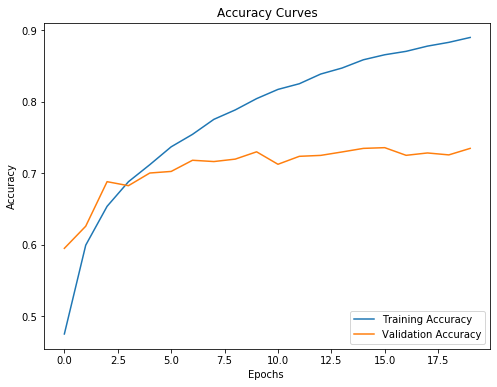

In [0]:
plot_curves(history)

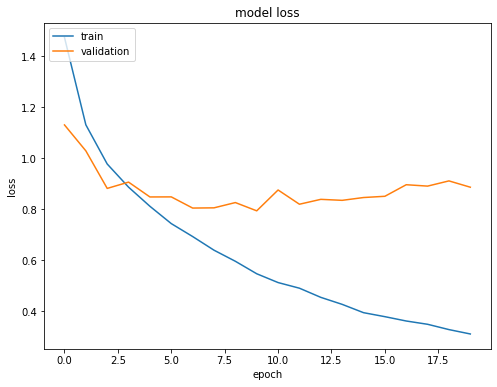

In [0]:
plot_losses(history)

In [0]:
score = model.evaluate(x_test, y_test, batch_size=128, verbose=0)

In [0]:
print(model.metrics_names)
print(score)

['loss', 'acc']
[0.9044249374389648, 0.7269]


### Final Network Architecture: Deep CNN with Data Augmentation and RMSProp Optimization

#### We can increase the accuracy of the training with multiple convolutional layers that can generalize better and learn intermediary features. Building a Deep Neural Network can be advantageous, but it runs the risk of overfitting very quickly. 

#### We will deal with the issue of overfitting with data augmentation to increase the size of the training set by adding extra copies of the training examples that have been modified with transformations that do not change the actual class. This will help our model generalize because there will be more instances for it to learn on. 

#### Our next challenge will be to carefully design our model in regards to regularization and fine tuning our hyperparameters. The learning rate is one of the most difficult hyperparamters because it significantly affects the model's performance. We can deal with this issue by optimizing our model with RMSProp, which will algorithmically change the gradient accumulation into an exponentially weighted moving average. Since RMSProp uses a decaying average, it can discard history to converge more rapidly after finding the convex bowl. We will need this because we will be training with over 300,000 parameters. 

#### We will also run this model on the testing data as validation because we already know that it will perform better than the rest. The Dropout rate will start a .4 and decrease slightly over the layers. We will also continue using a small amount of decay and Batch Normalization. Basically, this model is just a deeper version of the best model we trained above. 

In [0]:
import keras
from keras.models import Sequential
from keras.utils import np_utils
from keras.preprocessing.image import ImageDataGenerator
from keras.layers import Dense, Activation, Flatten, Dropout, BatchNormalization
from keras.layers import Conv2D, MaxPooling2D
from keras.datasets import cifar10
from keras import regularizers
from keras.callbacks import LearningRateScheduler
import numpy as np

def lr_schedule(epoch):
    lrate = 0.001
    if epoch > 75:
        lrate = 0.0005
    elif epoch > 100:
        lrate = 0.0003        
    return lrate

weight_decay = 1e-4
model = Sequential()
model.add(Conv2D(32, (3,3), padding='same', kernel_regularizer=regularizers.l2(weight_decay), input_shape=input_shape))
model.add(Activation('elu'))
model.add(BatchNormalization())
model.add(Conv2D(32, (3,3), padding='same', kernel_regularizer=regularizers.l2(weight_decay)))
model.add(Activation('elu'))
model.add(BatchNormalization())
model.add(MaxPooling2D(pool_size=(2,2)))
model.add(Dropout(0.2))

model.add(Conv2D(64, (3,3), padding='same', kernel_regularizer=regularizers.l2(weight_decay)))
model.add(Activation('elu'))
model.add(BatchNormalization())
model.add(Conv2D(64, (3,3), padding='same', kernel_regularizer=regularizers.l2(weight_decay)))
model.add(Activation('elu'))
model.add(BatchNormalization())
model.add(MaxPooling2D(pool_size=(2,2)))
model.add(Dropout(0.3))

model.add(Conv2D(128, (3,3), padding='same', kernel_regularizer=regularizers.l2(weight_decay)))
model.add(Activation('elu'))
model.add(BatchNormalization())
model.add(Conv2D(128, (3,3), padding='same', kernel_regularizer=regularizers.l2(weight_decay)))
model.add(Activation('elu'))
model.add(BatchNormalization())
model.add(MaxPooling2D(pool_size=(2,2)))
model.add(Dropout(0.4))

model.add(Flatten())
model.add(Dense(num_classes, activation='softmax'))

model.summary()

#data augmentation
datagen = ImageDataGenerator(
    rotation_range=15,
    width_shift_range=0.1,
    height_shift_range=0.1,
    horizontal_flip=True,
    )
datagen.fit(x_train)

#training
batch_size = 64

opt_rms = keras.optimizers.rmsprop(lr=0.001,decay=1e-6)
model.compile(loss='categorical_crossentropy', optimizer=opt_rms, metrics=['accuracy'])
history = model.fit_generator(datagen.flow(x_train, y_train, batch_size=batch_size),\
                    steps_per_epoch=x_train.shape[0] // batch_size,epochs=125,\
                    verbose=1,validation_data=(x_test,y_test),callbacks=[LearningRateScheduler(lr_schedule)])

Model: "sequential_9"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_17 (Conv2D)           (None, 32, 32, 32)        896       
_________________________________________________________________
activation_5 (Activation)    (None, 32, 32, 32)        0         
_________________________________________________________________
batch_normalization_5 (Batch (None, 32, 32, 32)        128       
_________________________________________________________________
conv2d_18 (Conv2D)           (None, 32, 32, 32)        9248      
_________________________________________________________________
activation_6 (Activation)    (None, 32, 32, 32)        0         
_________________________________________________________________
batch_normalization_6 (Batch (None, 32, 32, 32)        128       
_________________________________________________________________
max_pooling2d_9 (MaxPooling2 (None, 16, 16, 32)       

### Deep CNN Model Evaluation: 

#### We were successful in surpassing the industry standard of ~75% by creating a deeply multilayered CNN that utilized Batch Normalization, Data Augmentation, and RMSProp Optimization. Our final evaluation indicates that our model will generalize to new images of data in the 10 given classes and label them correctly with ~88% accuracy. Most importantly, our model will not overfit with a loss score of only 0.47.

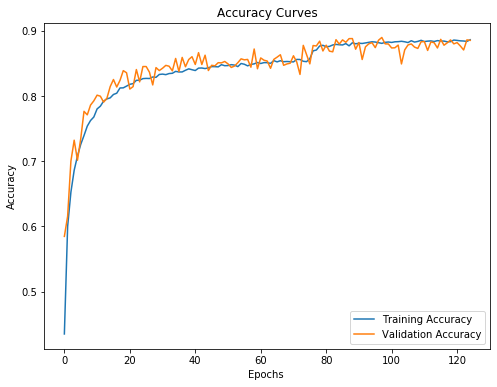

In [0]:
plot_curves(history)

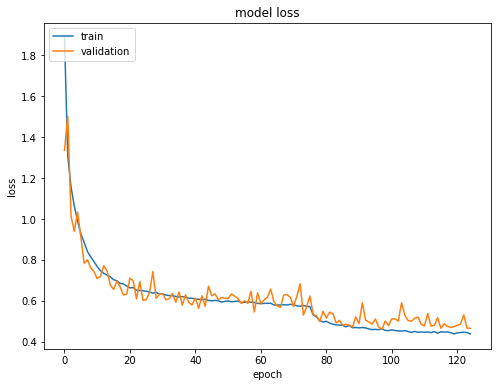

In [0]:
plot_losses(history)

### Final Score: 88.55%

In [0]:
scores = model.evaluate(x_test, y_test, batch_size=128, verbose=1)

10000/10000 [==============================] - 1s 60us/step


In [0]:
print(model.metrics_names)
print(scores)

['loss', 'acc']
[0.46566411571502686, 0.8855]


In [0]:
predictions = np.round(model.predict(x_test),0)

In [0]:
print("rounded test labels", predictions)

rounded test labels [[0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 1. 0.]
 [0. 0. 0. ... 0. 1. 0.]
 ...
 [0. 0. 0. ... 0. 0. 0.]
 [0. 1. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 1. 0. 0.]]


In [0]:
from sklearn import metrics
cifar_classes = ['airplane', 'automobile', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck']
classification_metrics = metrics.classification_report(y_test, predictions, target_names=cifar_classes)

/usr/local/lib/python3.6/dist-packages/sklearn/metrics/classification.py:1437: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in samples with no predicted labels.
  'precision', 'predicted', average, warn_for)


### Classification Metrics of our Final Model:

#### Interestingly, our f1-scores for the given objects were the strongest in "man-made" objects as opposed to objects found in nature, such as animals or pets. Automobiles and Trucks recieved the highest scores, while Cats and Dogs recieved the lowest f1-scores. Perhaps the shapes of animals are more difficult to learn than cars and trucks. This must be because the image vectors are more defined in box-like shapes as opposed to shapes of animals that have tails. 

In [0]:
print(classification_metrics)

              precision    recall  f1-score   support

    airplane       0.93      0.87      0.90      1000
  automobile       0.95      0.95      0.95      1000
        bird       0.92      0.80      0.86      1000
         cat       0.85      0.73      0.79      1000
        deer       0.86      0.92      0.89      1000
         dog       0.96      0.67      0.79      1000
        frog       0.88      0.94      0.91      1000
       horse       0.95      0.89      0.92      1000
        ship       0.95      0.93      0.94      1000
       truck       0.89      0.96      0.92      1000

   micro avg       0.91      0.87      0.89     10000
   macro avg       0.91      0.87      0.89     10000
weighted avg       0.91      0.87      0.89     10000
 samples avg       0.87      0.87      0.87     10000

